# SHAP for Heart Attack Analysis models

## Task B
Calculate Shapley values for player A given the following value function
```
v() = 0
v(A) = 20
v(B) = 20
v(C) = 60
v(A,B) = 60
v(A,C) = 70
v(B,C) = 70
v(A,B,C) = 100
```

$$ v(\{\} \cup A) - v(\{\}) = 20 $$
$$ v(\{B\} \cup A) - v(\{B\}) = 40 $$
$$ v(\{C\} \cup A) - v(\{C\}) = 10 $$
$$ v(\{B, C\} \cup A) - v(\{B, C\}) = 30 $$
$$ \phi_A(v) = \frac{1}{6}(\underbrace{20 * 2}_{A \cup \{B, C\}} + \underbrace{40}_{\{B\} \cup A \cup \{C\}} + \underbrace{10}_{\{C\} \cup A \cup \{B\}} + \underbrace{30 * 2}_{\{B, C\} \cup A}) = 25 $$

## Task A

In this work I will explain predictions obtained from a Random Forest model. I will use SHapley Additive exPlanations
implementations from 2 frameworks `dalex` and `shap`. Dataset used is The Heart Attack Analysis dataset
([source](https://www.kaggle.com/datasets/rashikrahmanpritom/heart-attack-analysis-prediction-dataset)).

Dataset attributes:

- Age : Age of the patient
- Sex : Sex of the patient
- exang: exercise induced angina (1 = yes; 0 = no)
- caa: number of major vessels (0-3)
- cp : Chest Pain type
    - Value 1: typical angina
    - Value 2: atypical angina
    - Value 3: non-anginal pain
    - Value 4: asymptomatic
- trtbps : resting blood pressure (in mm Hg)
- chol : cholestoral in mg/dl fetched via BMI sensor
- fbs : (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
- rest_ecg : resting electrocardiographic results
    - Value 0: normal
    - Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    - Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
- thalach : maximum heart rate achieved
- oldpeak : Previous peak
- slp : Slope
- target : 0= less chance of heart attack 1= more chance of heart attack
- thall : Thalium Stress Test result [0, 3]

I have preprocessed the dataset by one hot encoding categorical features.

## Two observations with different variable of the highest importance

![shap_task_4_1](imgs/shap_task_4_1.png)
![shap_task_4_2](imgs/shap_task_4_2.png)

For subject on the right 2 most important variables were "cp_3" (Chest Pain - Value 3: non-anginal pain) and "thalach"
(maximum heart rate). We can easily correlate having both chest pain and a high heart rate with the chance of having
a heart attack. For the subject on the left the 2 most important features are "oldpeak" and "thall_2". The value of
"oldpeak" (2.6) is substantially higher then average (1.04) which is probably why it is important.

Even though the 2 most important variables are different for the 2 subjects, we can see that all of the mentioned
features excluding "cp_3" are in top 6 most important features for both subjects.

## One variable with opposite attribution for two observations

![shap_task_5_1](imgs/shap_task_5_1.png)
![shap_task_5_2](imgs/shap_task_5_2.png)

I have searched for 2 observations that would have different (positive/negative) attribution for the "age" column with
absolute value higher than 0.07. What is interesting that the 2 found observations have at first glance unexpected
values of of the "age" variable. Namely the subject on the left that model predicted low chance of heart attack
has age=60 with negative attribution and subject on the right with positive attribution has age=41 and model predicted
them high chance of heart attack. Possible explanation is that the subject on the left is relatively healthy while being
older and subject on the right for his age has negative (unhealthy) scores for other variables.

## Differences between dalex and shap

![dx_task_3](imgs/dx_task_3.png)
![shap_task_3_1](imgs/shap_task_3_1.png)
![shap_task_3_2](imgs/shap_task_3_2.png)

The results between packages do not differ much. Most of the variables for both subjects have similar SHAP values for
both estimators and their relative importance with different variables are also similar (1-2 place differences
higher/lower). The one slightly bigger difference is the value for variable "thal_2" for subject 246.

## Another model (Logistic Regression) with different attributions to Random Forest

![shap_task_7_1](imgs/shap_task_7_1.png)
![shap_task_7_2](imgs/shap_task_7_2.png)

The attribution for 2 models are much different. What is very important to notice is that the logistic regression model
made a wrong prediction (and unconfident). Unsurprisingly for such small dataset Random Forest was able to perfectly
fit to the data and achieved 100% train accuracy. What it worth pointing out is that both "age" and "thalachh" variables
have low importance for the Regression model while here and previously they had relatively high importance for Random
Forest. I think that might be related to the fact that the data was not normalized and while it is not a problem for
a Tree model it could be for Regression.

## Appendix

### Install required packages.

In [1]:
%%capture
%pip install dalex jinja2 kaleido numpy nbformat pandas plotly torch scikit-learn shap

### Imports and loading dataset

In [1]:
import dalex as dx
import numpy as np
import pandas as pd
import plotly.express as px
import shap
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

rng = np.random.default_rng(0)

TARGET_COLUMN = "output"
df = pd.read_csv("heart.csv")
df.describe()

/home/krystian/PythonProjects/eXplainableMachineLearning-2023/.venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


Shuffling the data, extracting target column and one hot encoding categorical columns..

In [2]:
df = df.sample(frac=1, random_state=0).reset_index(drop=True)

y = df[[TARGET_COLUMN]]

x = df.drop(TARGET_COLUMN, axis=1)

categorical_cols = ["sex", "cp", "fbs", "restecg", "exng", "slp", "caa", "thall"]
numerical_cols = list(set(x.columns) - set(categorical_cols))

x = pd.get_dummies(x, columns=categorical_cols, drop_first=True)
n_columns = len(x.columns)

categorical_cols, numerical_cols

(['sex', 'cp', 'fbs', 'restecg', 'exng', 'slp', 'caa', 'thall'],
 ['chol', 'age', 'thalachh', 'trtbps', 'oldpeak'])

## Correlation matrix

Not being an expert in cardiology I plot correlation matrix to have a view how each column impacts the target.

In [3]:
corr_df = x.copy()
corr_df[TARGET_COLUMN] = y

corr = corr_df.corr("pearson")
corr.style.background_gradient(cmap='coolwarm')

,age,trtbps,chol,thalachh,oldpeak,sex_1,cp_1,cp_2,cp_3,fbs_1,restecg_1,restecg_2,exng_1,slp_1,slp_2,caa_1,caa_2,caa_3,caa_4,thall_1,thall_2,thall_3,output
age,1.000000,0.279351,0.213678,-0.398522,0.210013,-0.098447,-0.147399,-0.059432,0.047516,0.121308,-0.160654,0.084621,0.096801,0.177201,-0.192580,0.179284,0.226491,0.162243,-0.122378,0.063758,-0.135891,0.110752,-0.225439
trtbps,0.279351,1.000000,0.123174,-0.046698,0.193216,-0.056769,-0.081851,-0.045107,0.151343,0.177531,-0.146576,0.058635,0.067616,0.025207,-0.087472,-0.059485,0.088386,0.080109,0.019059,0.076369,-0.140712,0.109573,-0.144931
chol,0.213678,0.123174,1.000000,-0.009940,0.053952,-0.197912,-0.012750,-0.037918,-0.050589,0.013294,-0.174394,0.034615,0.067023,0.051177,-0.028054,0.018775,0.059887,0.098568,-0.095785,-0.093560,-0.004591,0.059621,-0.085239
thalachh,-0.398522,-0.046698,-0.009940,1.000000,-0.344187,-0.044020,0.248317,0.165475,0.079082,-0.008567,0.101512,-0.120870,-0.378812,-0.419627,0.448043,-0.195502,-0.056905,-0.175506,0.060911,-0.159748,0.294801,-0.215417,0.421741
oldpeak,0.210013,0.193216,0.053952,-0.344187,1.000000,0.096093,-0.277513,-0.132444,0.086959,0.005747,-0.138486,0.168172,0.288223,0.310986,-0.511356,-0.011613,0.218319,0.189296,-0.104998,0.104635,-0.339086,0.302145,-0.430696
sex_1,-0.098447,-0.056769,-0.197912,-0.044020,0.096093,1.000000,-0.041249,-0.116588,0.088043,0.045032,-0.011940,-0.107689,0.141664,-0.009157,-0.014356,0.096673,-0.020571,0.066758,0.088212,0.141135,-0.376365,0.321559,-0.280937
cp_1,-0.147399,-0.081851,-0.012750,0.248317,-0.277513,-0.041249,1.000000,-0.282135,-0.127412,-0.060649,0.105226,-0.051418,-0.233863,-0.197994,0.223921,-0.059046,-0.087804,-0.082372,0.012208,-0.036496,0.207354,-0.188225,0.245879
cp_2,-0.059432,-0.045107,-0.037918,0.165475,-0.132444,-0.116588,-0.282135,1.000000,-0.181894,0.083679,0.092738,-0.009492,-0.271028,-0.105320,0.120276,0.023753,-0.196274,-0.021817,0.089577,-0.097775,0.210130,-0.173717,0.316742
cp_3,0.047516,0.151343,-0.050589,0.079082,0.086959,0.088043,-0.127412,-0.181894,1.000000,0.055511,-0.063252,-0.033150,-0.093384,0.009321,-0.044421,-0.058710,0.041972,-0.076192,-0.037125,0.033404,0.009998,-0.022554,0.086957
fbs_1,0.121308,0.177531,0.013294,-0.008567,0.005747,0.045032,-0.060649,0.083679,0.055511,1.000000,-0.066344,-0.048305,0.025665,-0.033360,-0.020255,-0.014774,0.122080,0.075867,0.018754,0.091351,-0.086774,0.030953,-0.028046


## Random Forest model

In [4]:
model = RandomForestClassifier(random_state=0).fit(x, y)

accuracy_score(y, model.predict(x))

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


1.0

## Task 3
Select 2 samples with different output from the dataset.

In [5]:
sample_ids = [203, 246]
sample_ids
df.iloc[sample_ids]

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
203,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
246,35,0,0,138,183,0,1,182,0,1.4,2,0,2,1


In [6]:
def dx_predict_func(m, d): 
    return m.predict_proba(d)[:, 1]

def shap_predict_func(d):
    return model.predict_proba(d)[:, 1]

dx_explainer = dx.Explainer(model, x, y, predict_function=dx_predict_func, label="")

shap_explainer = shap.Explainer(shap_predict_func, x)
shap_values = shap_explainer(x)

def plot_both(ids):
    dx_attributions = [dx_explainer.predict_parts(x.iloc[[i]], type="shap", label=f'passenger {i}') for i in ids]
    dx_attributions[0].plot(dx_attributions[1::], max_vars=n_columns)

    for i in ids:
        shap.plots.waterfall(shap_values[i], max_display=n_columns)

Preparation of a new explainer is initiated

  -> data              : 303 rows 22 cols
  -> target variable   : Parameter 'y' was a pandas.DataFrame. Converted to a numpy.ndarray.
  -> target variable   : 303 values
  -> model_class       : sklearn.ensemble._forest.RandomForestClassifier (default)
  -> label             : 
  -> predict function  : <function dx_predict_func at 0x7fb9b6245af0> will be used
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0, mean = 0.547, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.39, mean = -0.00238, max = 0.34
  -> model_info        : package sklearn

A new explainer has been created!


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
Permutation explainer: 304it [01:10,  3.80it/s]                         


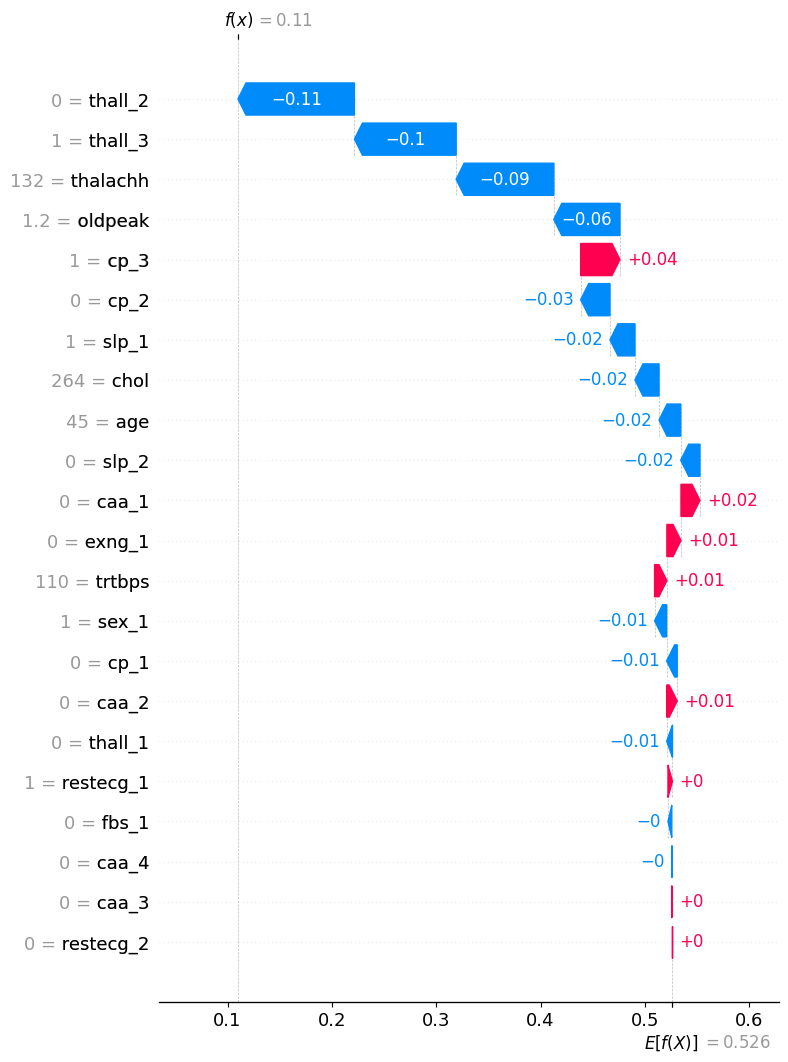

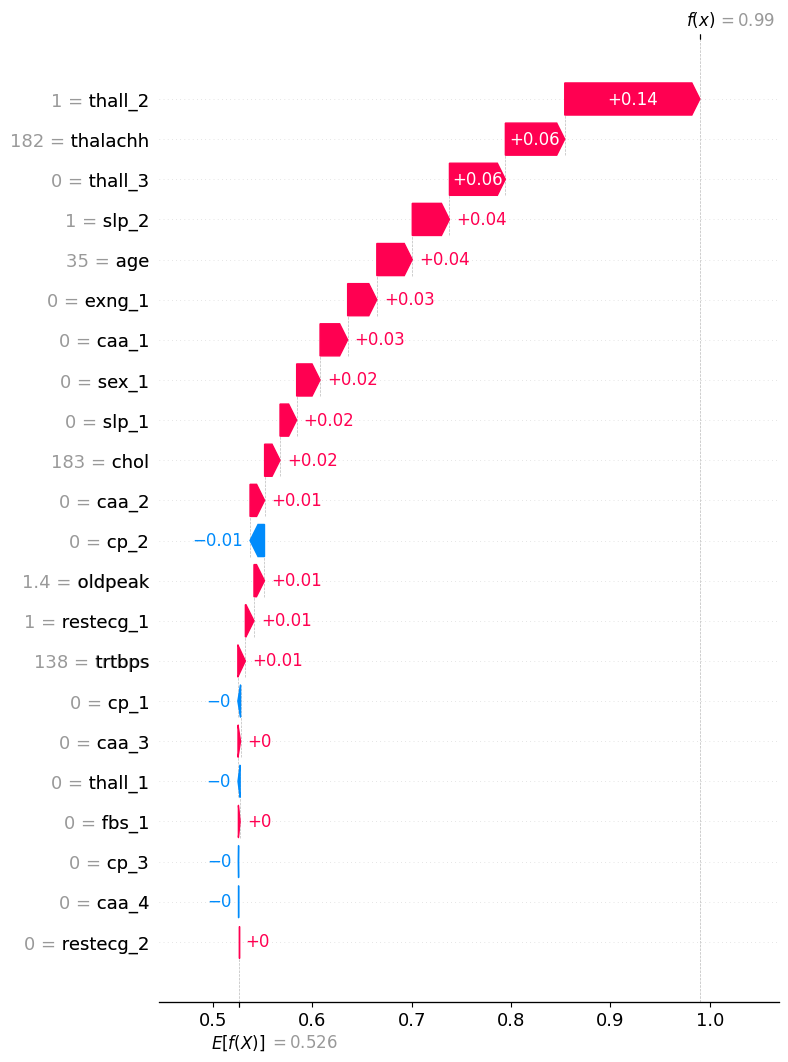

In [7]:
plot_both(sample_ids)

## Task 4 - 2 observations with different variables of the highest importance

In [8]:
vars_sorted = np.argsort(np.abs(shap_values.values), axis=1)[:, -2:]
different_vars_ids = [0, 0]
different_vars = [vars_sorted[different_vars_ids[0]], 0]

different_vars_ids[1] = np.where(np.logical_and(np.all(vars_sorted != different_vars[0], axis=1), np.all(vars_sorted != np.flip(different_vars[0]), axis=1)))[0][0]
different_vars[1] = vars_sorted[different_vars_ids[1]]

df.iloc[different_vars_ids]

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
1,64,1,3,170,227,0,0,155,0,0.6,1,0,3,1


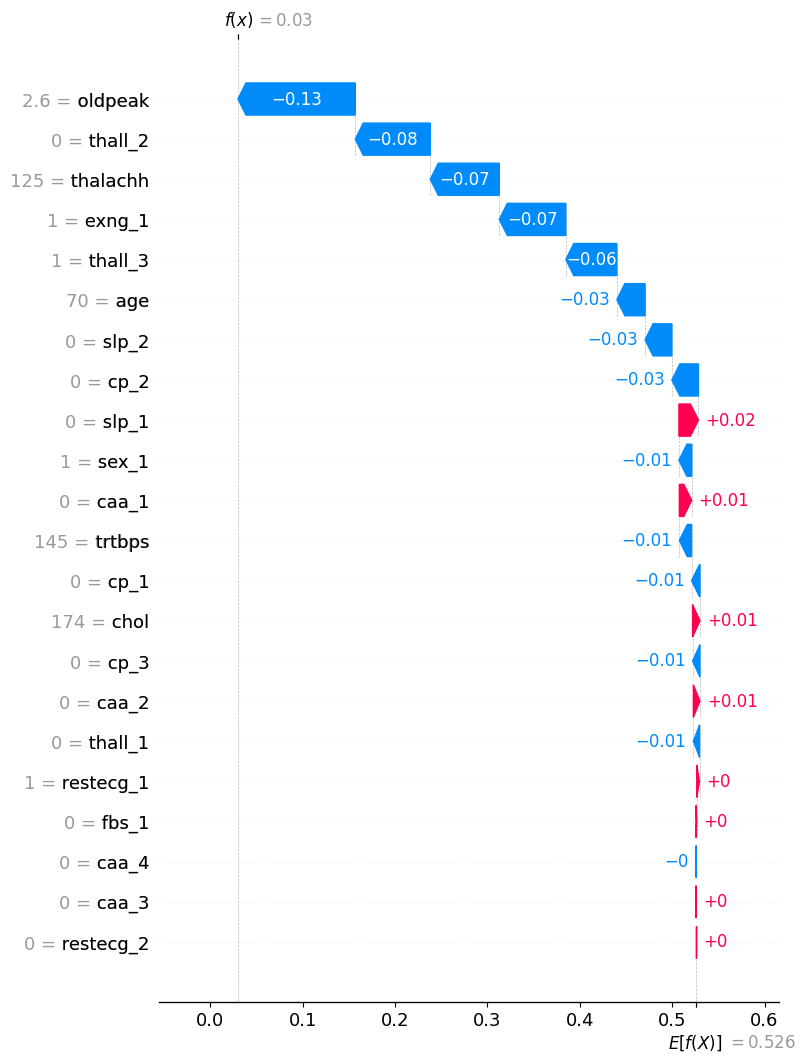

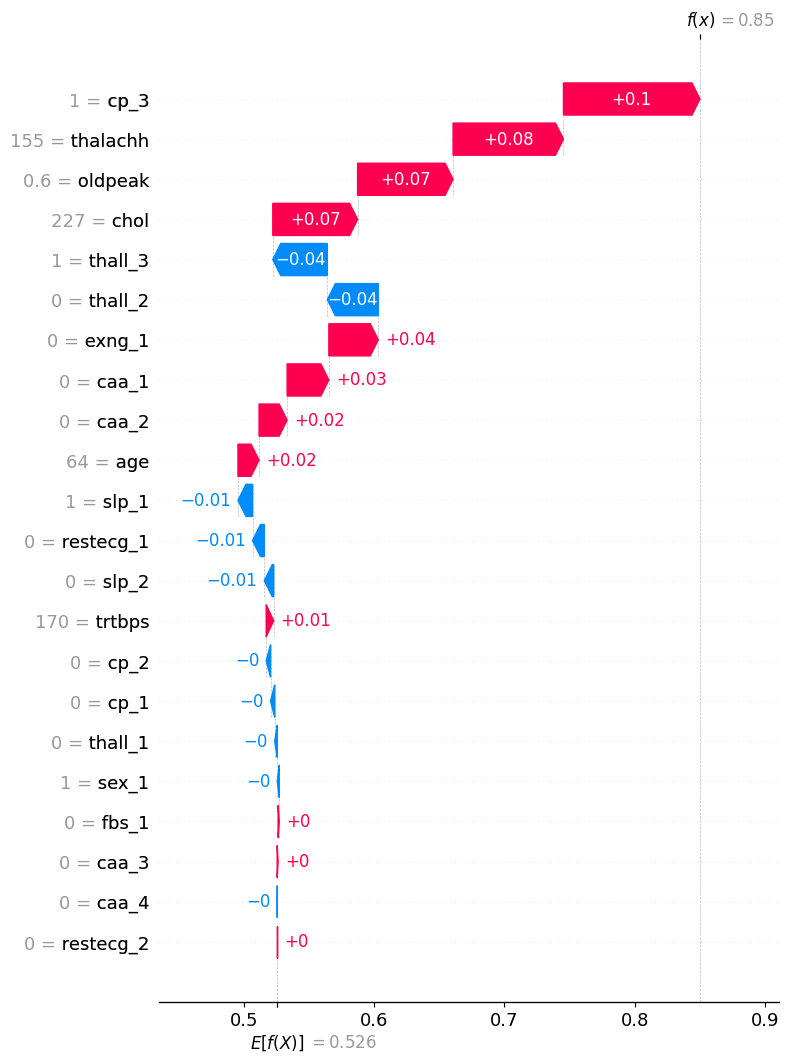

In [9]:
plot_both(different_vars_ids)

## Task 5 - 2 observations with different attribution for the same variable

In [13]:
different_attribution_column = "age"
different_attribution_column_id = [column == different_attribution_column for column in x.columns]

different_attribution_ids_1 = np.where(x[different_attribution_column])[0]
negative_attribution_ids = different_attribution_ids_1[np.where(shap_values.values[different_attribution_ids_1, different_attribution_column_id] < -0.07)[0]]
positive_attribution_ids = different_attribution_ids_1[np.where(shap_values.values[different_attribution_ids_1, different_attribution_column_id] > 0.07)[0]]

negative_attribution_ids, positive_attribution_ids

(array([ 30,  35,  39,  57,  64,  66,  90, 100, 105, 106, 187, 204, 206,
        232, 256, 275, 302]),
 array([ 46, 240]))

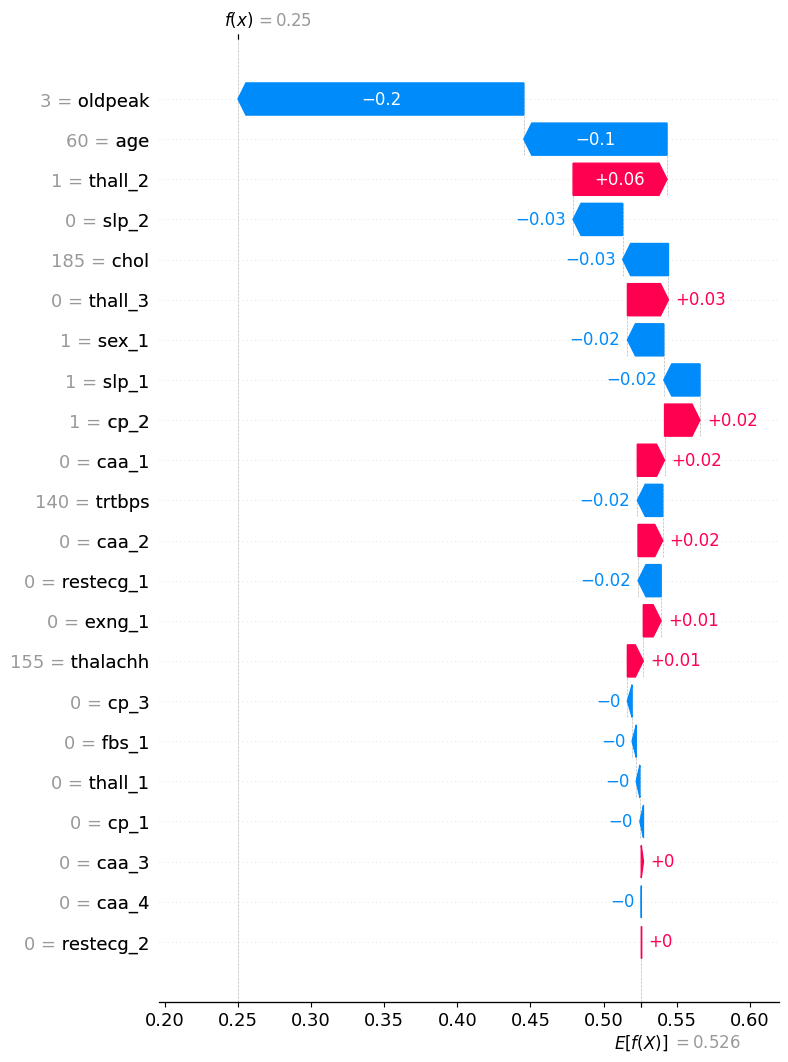

In [14]:
plot_both(negative_attribution_ids[:1])

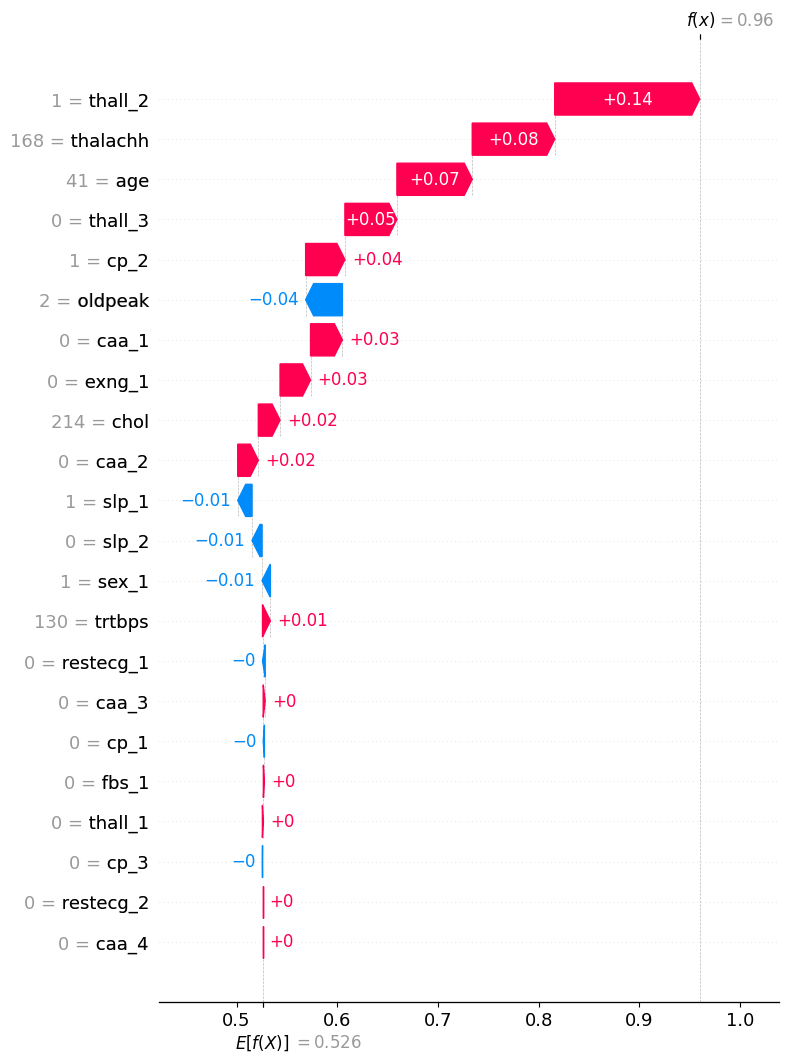

In [15]:
plot_both(positive_attribution_ids[:1])

## Task 7 - Another model - Logistic Regression

In [16]:
lr_clf = RidgeClassifier(random_state=0).fit(x, y.squeeze())

def lr_shap_predict_func(d):
    pred = lr_clf.decision_function(d)
    return 1 / (1 + np.exp(-pred))

lr_shap_explainer = shap.Explainer(lr_shap_predict_func, x)
lr_shap_values = lr_shap_explainer(x)

accuracy_score(y, lr_clf.predict(x))

Permutation explainer: 304it [00:10,  1.49s/it]                         


0.8778877887788779

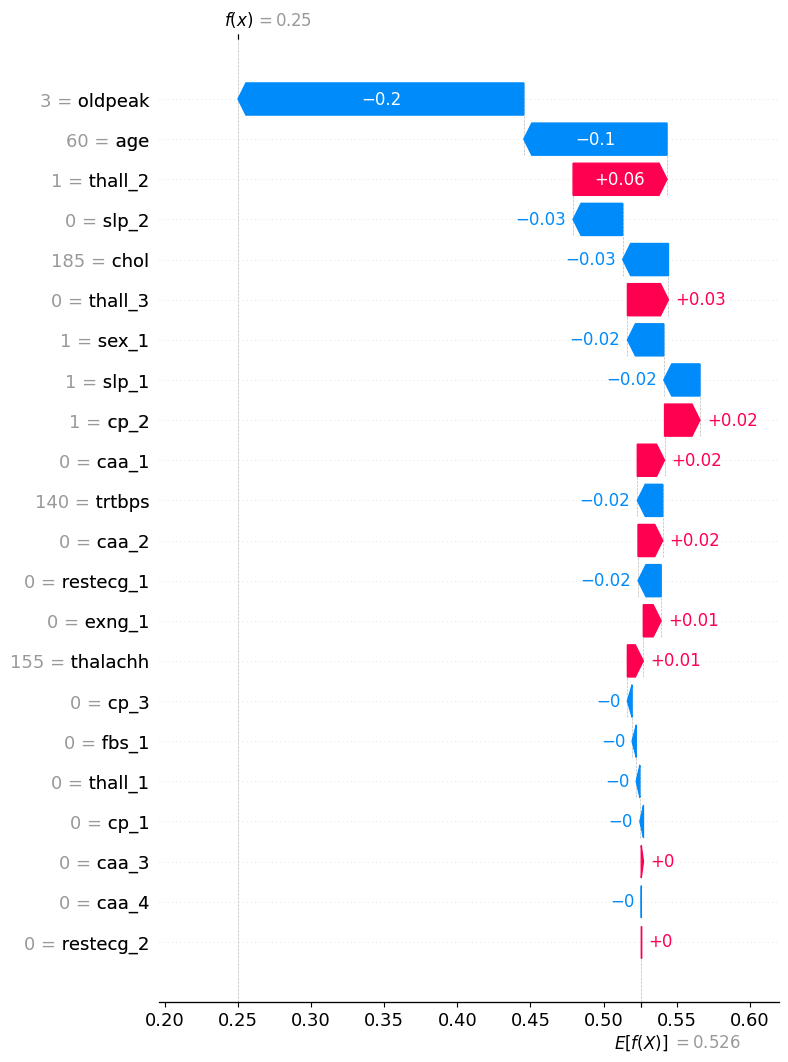

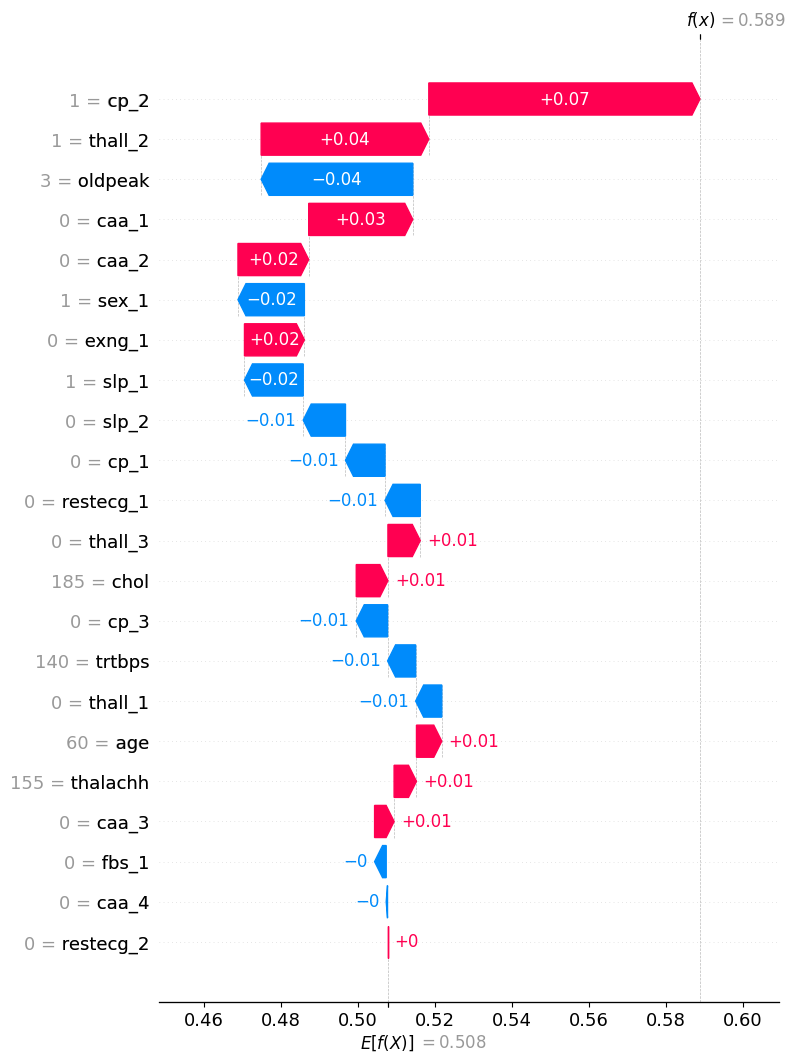

In [17]:
models_differ_id = np.where(np.any(np.logical_not(np.isclose(shap_values.values, lr_shap_values.values, atol=0.15)), axis=1))[0][0]

shap.plots.waterfall(shap_values[models_differ_id], max_display=n_columns)
shap.plots.waterfall(lr_shap_values[models_differ_id], max_display=n_columns)